# Multi Resolution Simulation

### Classes and modules

In [22]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [23]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [24]:
%cuda_context_handler gpu_ctx

In [25]:
%cuda_context_handler gpu_ctx0

In [26]:
%cuda_context_handler gpu_ctx1

In [27]:
%cuda_context_handler gpu_ctx2

In [28]:
%cuda_context_handler gpu_ctx3

In [29]:
%cuda_context_handler gpu_ctx4

## Setting-up case with different resolutions

IC are the bump from the Rossby adjustment case

In [30]:
def initBump(data_args, dataShape, d_shift=1e6,D=0.5*1e6):

    eta0  = np.zeros(dataShape, dtype=np.float32, order='C')
    hu0   = np.zeros(dataShape, dtype=np.float32, order='C')
    hv0   = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = data_args["dx"]*(data_args["nx"]+4)*0.5
    y_center = data_args["dy"]*(data_args["ny"]+4)*0.5

    scale = 1e9
    for j in range(data_args["ny"] + 4):
        for i in range(data_args["nx"] + 4):
            x = data_args["dx"]*i - x_center
            y = data_args["dy"]*j - y_center

            d = np.sqrt(x**2 + y**2)
            
            eta0[j, i] += 0.1*(1.0+np.tanh(-(d-d_shift)/D))

    return eta0, hu0, hv0

In [31]:
def initLevel(l):
    data_args = {}
    data_args["nx"] = 2**l
    data_args["ny"] = 2**l 
    dataShape = (data_args["ny"] + 4, data_args["nx"] + 4)

    data_args["dx"] = 2**(19-l)*100
    data_args["dy"] = 2**(19-l)*100

    data_args["dt"] = 0.0
    data_args["g"] = 9.81
    data_args["f"] = 1.2e-4
    data_args["r"] = 0.0
    # data_args["boundary_conditions"] = Common.BoundaryConditions(1,1,1,1)

    data_args["eta0"], data_args["hu0"], data_args["hv0"] = initBump(data_args, dataShape)
    
    H0 = 1000.0
    data_args["H"] = np.ma.array(np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0, mask=False)

    return data_args

In [32]:
ls = [6, 7, 8, 9, 10]

Text(0.5, 0.75, 'Initial Conditions')

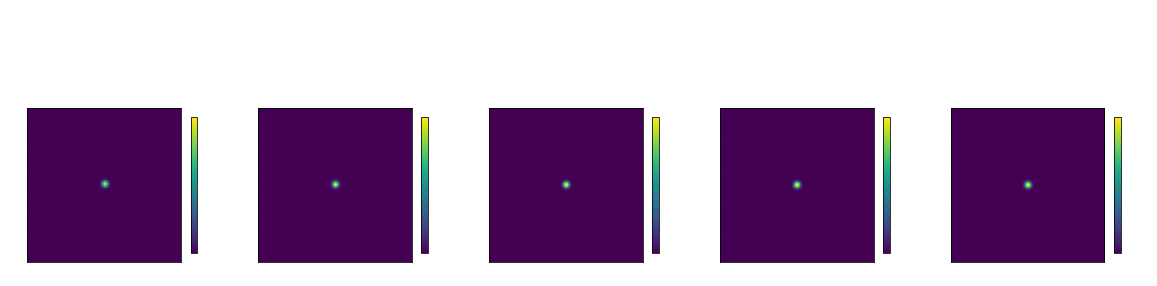

In [33]:
fig, axs = plt.subplots(1,len(ls), figsize=(20,10))

for l_idx, l in enumerate(ls):
    data_args = initLevel(l)
    im = axs[l_idx].imshow(data_args["eta0"])
    plt.colorbar(im, ax=axs[l_idx], shrink=0.25)

plt.suptitle("Initial Conditions", y=0.75)

### (Deterministic) Simulation on different Resolutions

In [34]:
for l_idx, l  in enumerate(ls):
    data_args = initLevel(l)
    exec("sim"+str(l_idx)+" = CDKLM16.CDKLM16(gpu_ctx"+str(l_idx)+", **data_args)")
    exec("sim"+str(l_idx)+".step(250000)")

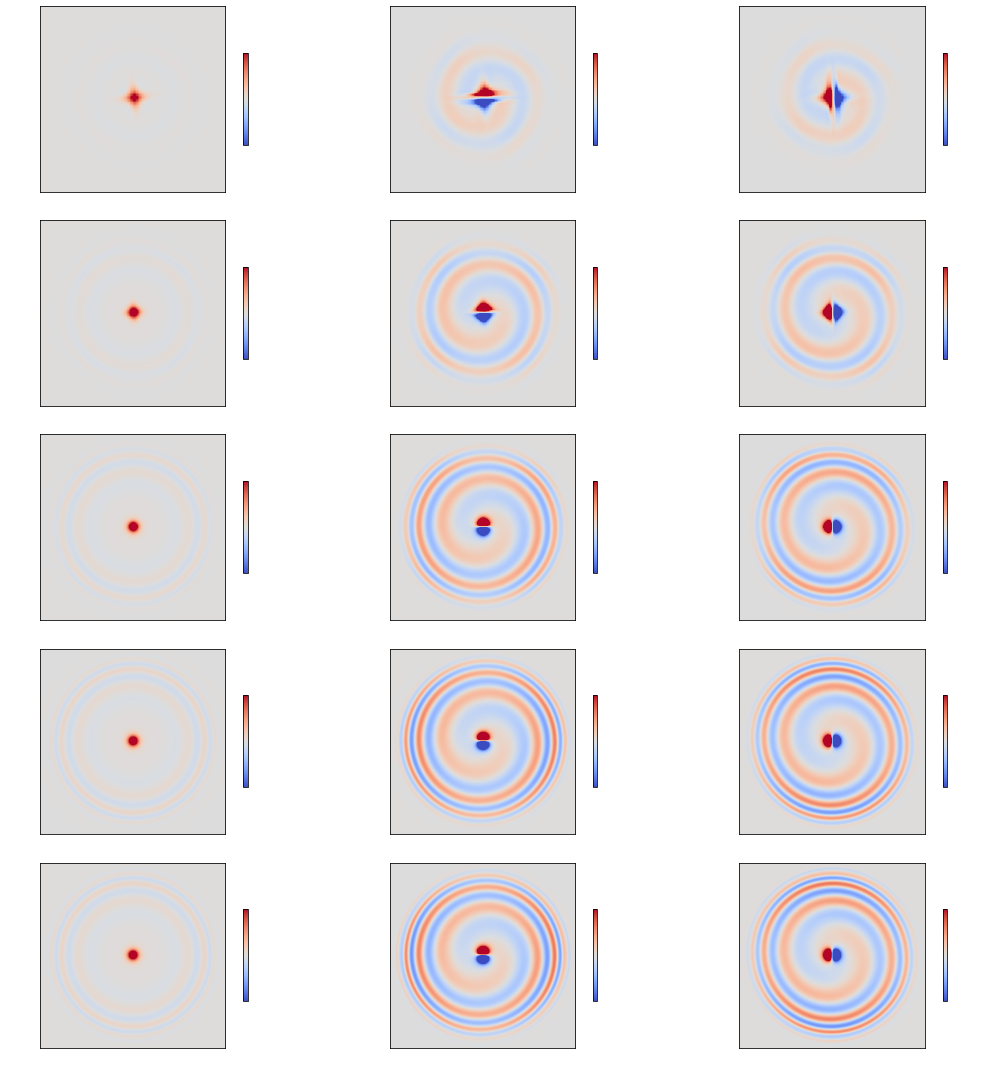

In [35]:
fig, axs = plt.subplots(len(ls),3, figsize=(15,15))

for j in range(len(ls)):
    for i in range(3):
        if i == 0: 
            vlim = 0.05
        else: 
            vlim = 1
        im = axs[j,i].imshow(eval("sim"+str(j)).download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
        plt.colorbar(im, ax=axs[j,i], shrink=0.5)
plt.tight_layout()

### Perturbation from wind direction

Wind field is faded out towards the walls. 
*So far only one random parameter but Matern field of wind intended.*

In [36]:
def wind_bump(ny, nx, sig = None):
    dataShape = (ny, nx )
    w = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = 0.5*nx
    y_center = 0.5*ny

    if sig is None:
        sig = nx**2/10

    for j in range(ny):
        for i in range(nx):
            x = i - x_center
            y = j - y_center

            d = x**2 + y**2
            
            w[j, i] = np.exp(-1/2*d/sig)    
    
    return w


In [37]:
wind_N = 100
wind_weight = wind_bump(wind_N,wind_N)

In [38]:
t_splits = 251

In [39]:
def KL_perturbations(t_splits, KL_N):
    # Sampling random field based on Karhunen-Loeve expansions
    
    # t_splits (int) - number of how many KL-fields are generated

    # Output: size=(t_splits, N, N) with t_splits-times a KL-field

    KL_DECAY=1.05
    KL_SCALING=0.15

    KL_fields = np.zeros((t_splits,KL_N,KL_N))

    rns = np.random.normal(size=(10,10,t_splits))

    for n in range(1, rns.shape[1]+1):
        for m in range(1, rns.shape[0]+1):
            KL_fields += np.tile(KL_SCALING * m**(-KL_DECAY) * n**(-KL_DECAY) * np.outer(np.sin(m*np.pi*np.linspace(0,1,KL_N)), np.sin(n*np.pi*np.linspace(0,1,KL_N))), (t_splits,1,1)) * rns[m-1, n-1][:,np.newaxis,np.newaxis]

    return KL_fields

In [40]:
## KL perturbed wind fields (much faster!)

wind_degree = np.deg2rad(np.random.uniform(0,360))
wind_speed  = 5.0

init_wind_u = wind_speed * np.sin(wind_degree) * np.ones((wind_N,wind_N))
init_wind_v = wind_speed * np.cos(wind_degree) * np.ones((wind_N,wind_N))

KL_fields_u = KL_perturbations(t_splits, wind_N)
KL_fields_v = KL_perturbations(t_splits, wind_N)

wind_u = np.repeat(init_wind_u[np.newaxis,:,:], t_splits, axis=0) + np.cumsum(KL_fields_u, axis=0)
wind_v = np.repeat(init_wind_v[np.newaxis,:,:], t_splits, axis=0) + np.cumsum(KL_fields_v, axis=0)

wind_u = wind_u *np.repeat(wind_weight[np.newaxis,:,:], t_splits, axis=0)
wind_v = wind_v *np.repeat(wind_weight[np.newaxis,:,:], t_splits, axis=0)

ts = np.linspace(0,250000,t_splits)

wind = WindStress.WindStress(t=ts, wind_u=wind_u.astype(np.float32), wind_v=wind_v.astype(np.float32))

Text(0.5, 1.0, 'wind_v')

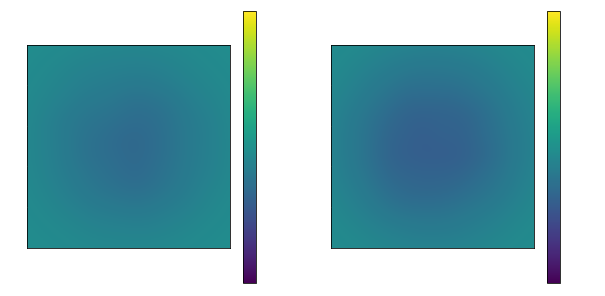

In [41]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

im = axs[0].imshow(wind.wind_u[0], vmin=-10, vmax=10)
plt.colorbar(im, ax=axs[0], shrink=0.5)
axs[0].set_title("wind_u")

im = axs[1].imshow(wind.wind_v[0], vmin=-10, vmax=10)
plt.colorbar(im, ax=axs[1], shrink=0.5)
axs[1].set_title("wind_v")


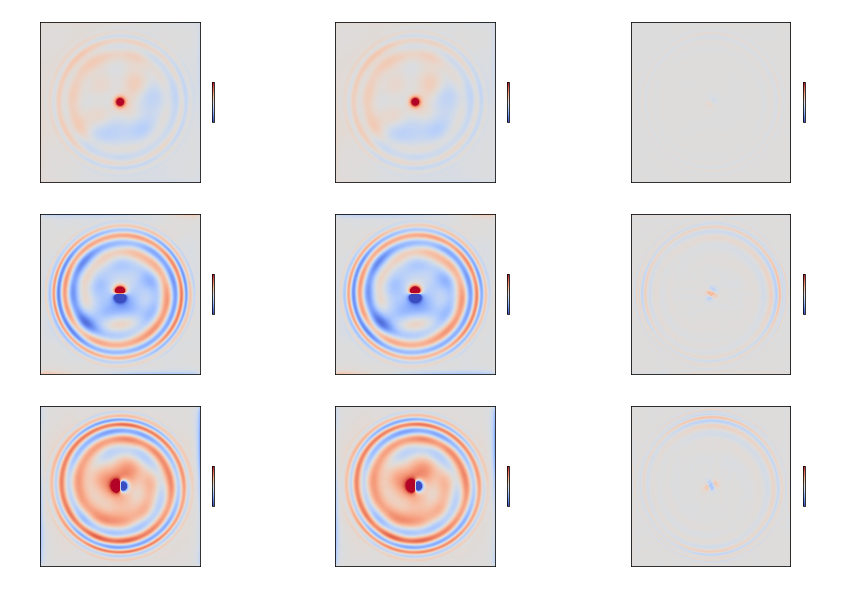

In [42]:
# Fine sim
l = 10
data_args = initLevel(l)
sim0 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim0.step(250000)

# Coarse partner
data_args = initLevel(l-1)
sim1 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim1.step(250000)


fig, axs = plt.subplots(3,3, figsize=(15,10))
labels = ["eta", "hu", "hv"]
for i in range(3):
    if i == 0: 
        vlim = 0.05
    else: 
        vlim = 1
    im = axs[i,0].imshow(sim0.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,0], shrink=0.25)
    axs[i,0].set_title("Fine "+labels[i])
    im = axs[i,1].imshow(sim1.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,1], shrink=0.25)
    axs[i,1].set_title("Coarse "+labels[i])

    im = axs[i,2].imshow(sim0.download(interior_domain_only=True)[i] - sim1.download(interior_domain_only=True)[i].repeat(2,0).repeat(2,1), vmin=-0.5*vlim, vmax=0.5*vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,2], shrink=0.25)
    axs[i,2].set_title("Difference "+labels[i])